# Beer Clustering

In [24]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist
import time

In [2]:
#Lectura del dataset
df = pd.read_csv('beer_reviews/beer_reviews.csv', header = 0)

## Descripción del dataset

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


/home/matias/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,NaN,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,NaN,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,NaN,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


El dataset utilizado proviene de la página web www.beeradvocate.com. En sus foros se publican reviews de cervezas (utilizando el sistema de puntuación establecido para ello) con el fin de entregar información objetiva los consumidores. 

El dataset contiene más de 1.500.000 reviews. Los siguientes atributos corresponden al sistema de puntuación, estos se miden en una escala de 1 a 5 con incremetos de 0.25:
<ul>
<li><b>review_overall:</b> Describe the overall impression of the beer.
<li><b>review_aroma:</b> Describe any malt, hops, yeast and other aromatics.
<li><b>review_appearance:</b> Describe the beer's color, clarity, head retention and lacing.
<li><b>review_palate:</b> Describe the beer's body, carbonation, warmth, creaminess, astringency and other palate sensations.
<li><b>review_taste:</b> Describe any malt, hops, fermentation byproducts, balance, finish or aftertaste and other flavor characteristics.
<li><b>beer_abv:</b> Average score.
</ul>

Cada ejemplo también cuenta con datos relacionados al producto y el usuario.
<ul>
<li><b>brewery_id:</b>ID de la cervecería (entero).
<li><b>beer_beerid:</b>ID de la cerveza (entero).
<li><b>brewery_name:</b> Nombre de la cervecería (texto).
<li><b>review_time:</b> (entero)
<li><b>review_profilename:</b> Nombre del usuario (texto).
<li><b>beer_style:</b> Tipo de cerveza (texto).
<li><b>beer_name:</b> Nombre de la cerveza (texto)
</ul>

## Test de algoritmos de clustering

Para visualizar los resultados de los distintos algoritmos de clustering, se proyectó el dataset a un manifold 2D utilizando Spectral Embedding.

### a) K-Means

Debido a la naturaleza del algoritmo se descartaron todas las características en formato de texto (brewery_name, review_profilename, beer_style, beer_name).

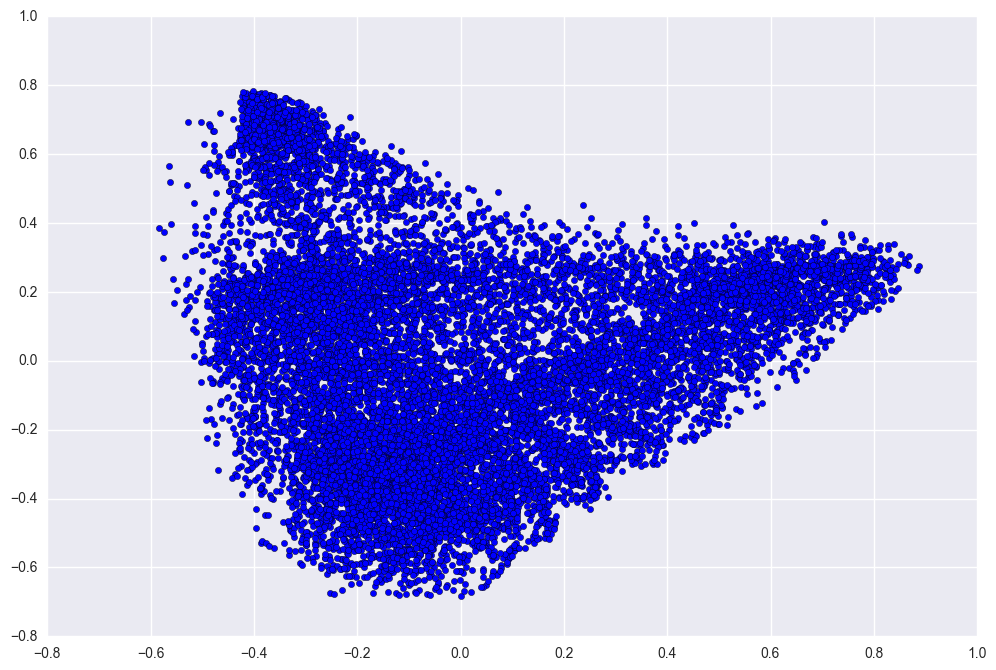

In [3]:
df = df.drop('brewery_name', axis=1)
df = df.drop('review_profilename', axis=1)
df = df.drop('beer_style', axis=1)
df = df.drop('beer_name', axis=1)
#df = df.drop('brewery_id',axis=1)
#df = df.drop('beer_beerid',axis=1)
#df = df.drop('review_time',axis=1)
df = df.sample(frac=.01)
df = df[np.isfinite(df['beer_abv'])]
df = StandardScaler().fit_transform(df)
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(df)
plt.figure(figsize=(12, 8))
plt.scatter(X_red[:, 0],X_red[:, 1])
plt.show()

Para escoger el número de clusters se utilizó el elbow method.

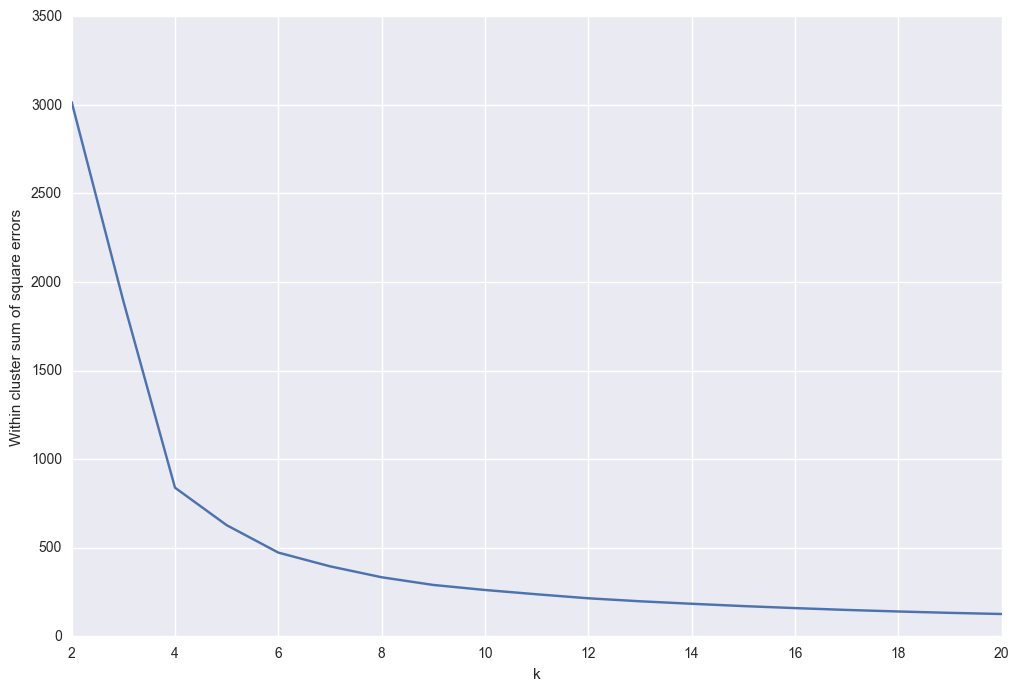

In [15]:
def elbow(df, n_clusters):
    kMeansVar = [KMeans(n_clusters=k).fit(df) for k in range(1, n_clusters)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    plt.figure(figsize=(12, 8))
    plt.plot(range(2,21),wcss)
    plt.ylabel('Within cluster sum of square errors')
    plt.xlabel('k')
    plt.show()
    
elbow(X_red,20)

Del gráfico anterior se concluye que los mejores valores de k se encuentra dentro del intervalo [2,6]. Dado que se obtuvo un rango de valores, se analizó el Silhouette Score para cada uno de ellos para determinar el k final. Éste score, mide la similitud entre un ejemplo con el cluster al que pertence, y también con los k-1 restantes. Su valor se encuentran dentro del intervalo [-1, 1], en donde un valor cercano a 1 indica una alta similaridad.

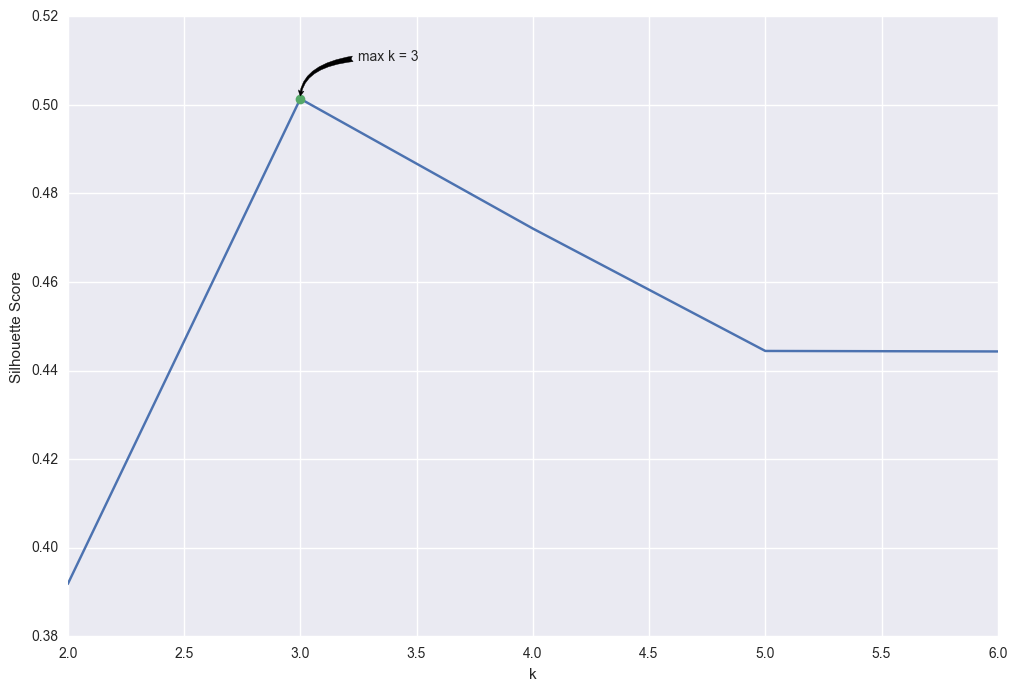

In [17]:
sc = []
for n_clusters in range(2,7):
    kmeans = KMeans(n_clusters=n_clusters).fit(X_red)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    sc.append(silhouette_score(X_red, labels, metric='euclidean'))

plt.figure(figsize=(12, 8))
plt.plot(range(2,7),sc)
plt.plot(np.argmax(sc)+2, np.amax(sc),'o')
plt.annotate('max k = 3', xy=(np.argmax(sc)+2, np.amax(sc)), xytext=(3.25, 0.51),
            arrowprops=dict(facecolor='black', arrowstyle = 'fancy',
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.ylabel("Silhouette Score")
plt.xlabel("k")
sns.despine()
plt.show()

En el gráfico se observa que el Silhouette Score alcanza un valor máximo en k = 3, y luego decae drásticamente para valores mayores de k, lo que indica que la cohesión de los clusters disminuye al aumentar su cantidad.

In [18]:
print("Max Silhouette Score = {} (k = {})" ).format(np.amax(sc),np.argmax(sc)+2)

Max Silhouette Score = 0.501384444905 (k = 3)


In [40]:
t0 = time.time()
kmeans = KMeans(n_clusters=3).fit(X_red)
t_kmeans = time.time() - t0

### b)  Mini Batch K-Means

In [41]:
t0 = time.time()
mbkmeans = MiniBatchKMeans(n_clusters=3).fit(X_red)
t_mbkmeans = time.time() - t0

### c) HAC Complete

In [29]:
t0 = time.time()
hac = HAC(n_clusters=3,linkage='complete').fit(X_red)
t_hac = time.time() - t0

### d) Ward

In [30]:
t0 = time.time()
ward = HAC(n_clusters=3,linkage='ward').fit(X_red)
t_ward = time.time() - t0

### e) DBSCAN

In [31]:
t0 = time.time()
dbscan = DBSCAN().fit(X_red)
t_dbscan = time.time() - t0

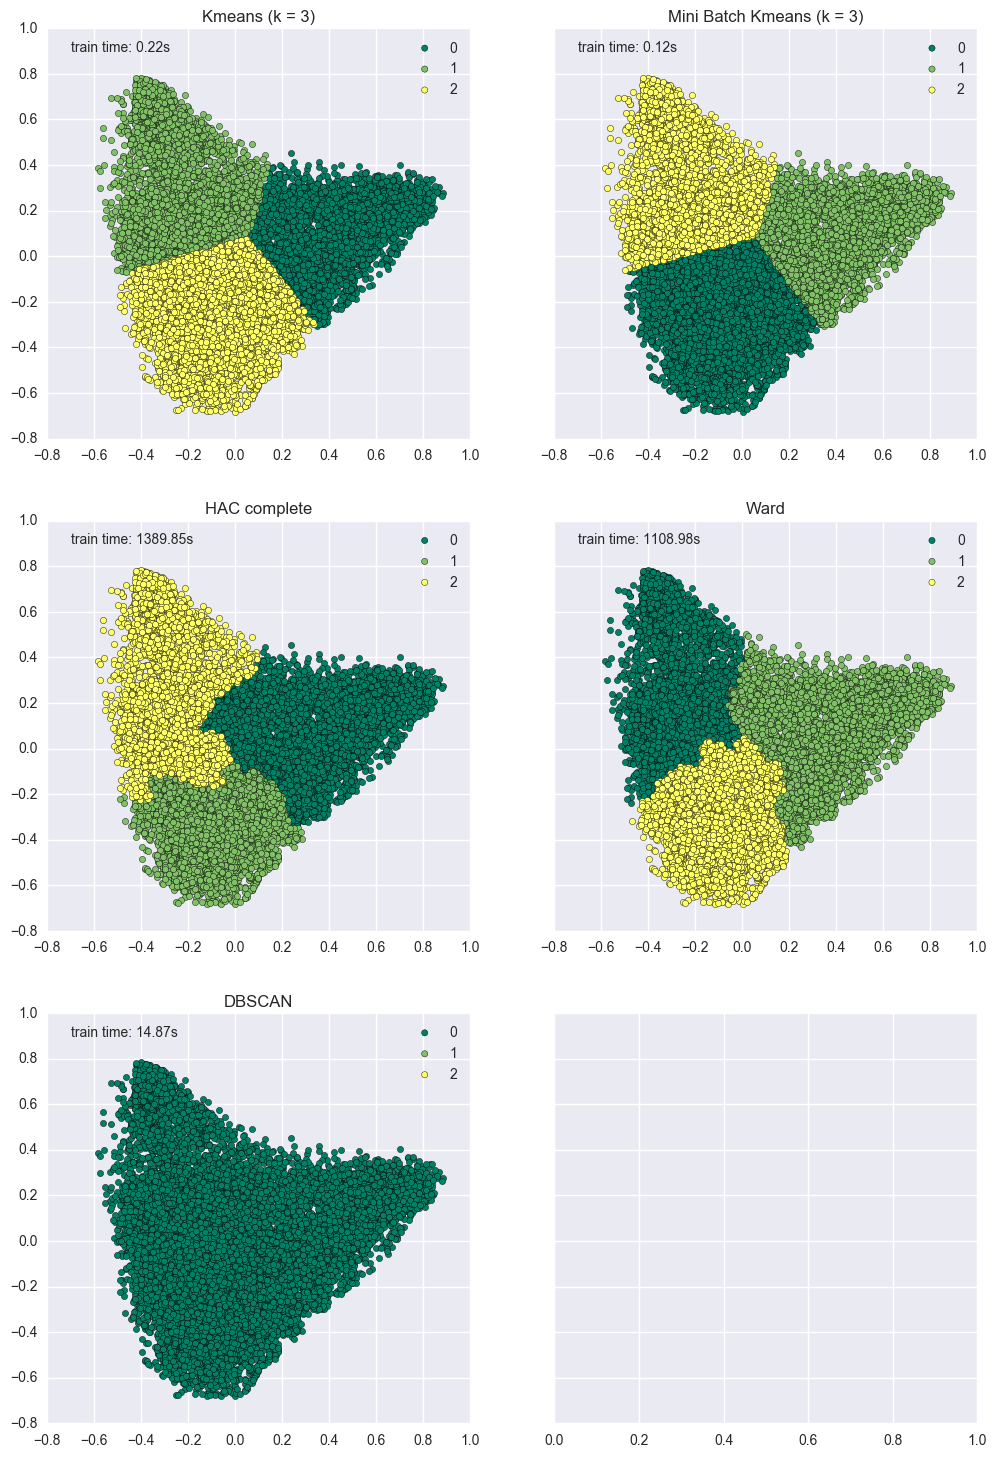

In [42]:
techniques = {"Kmeans (k = 3)":[0,0,kmeans.labels_,t_kmeans], 
              "Mini Batch Kmeans (k = 3)":[0,1,mbkmeans.labels_,t_mbkmeans],
              "HAC complete":[1,0,hac.labels_,t_hac],
              "Ward":[1,1,ward.labels_,t_ward],
              "DBSCAN":[2,0,dbscan.labels_,t_dbscan]
             }

f, axarr = plt.subplots(3, 2,sharey='row',figsize=(12, 18))
cmap = plt.cm.get_cmap('summer')
mclasses=(0,1,2)
mcolors = [cmap(i) for i in np.linspace(0,1,3)]

for key, value in techniques.iteritems():
    axarr[value[0],value[1]].set_title(key)
    for lab, col in zip(mclasses,mcolors):
        axarr[value[0],value[1]].scatter(X_red[value[2]==lab, 0],X_red[value[2]==lab, 1],
                                         label=lab,c=col)
    axarr[value[0],value[1]].legend(loc='upper right', fancybox=True)
    axarr[value[0],value[1]].text(-0.7, 0.9, 'train time: %.2fs' %
         (value[3]))
#TODO: add center in kmeans y mini batch
    #for center in kmeans.cluster_centers_:
        #plt.scatter(center[0],center[1],s = 60,color='black')
plt.show()

Se puede observar que los métodos con menor tiempo de entrenamiento corresponden a Kmeans y Mini Batch Kmeans, siendo este último levemente más rápido debido a que procesa el dataset por lotes. Los clusters entregados por cada algoritmos difieren levemente, esto se puede observar en el siguiente gráfico.

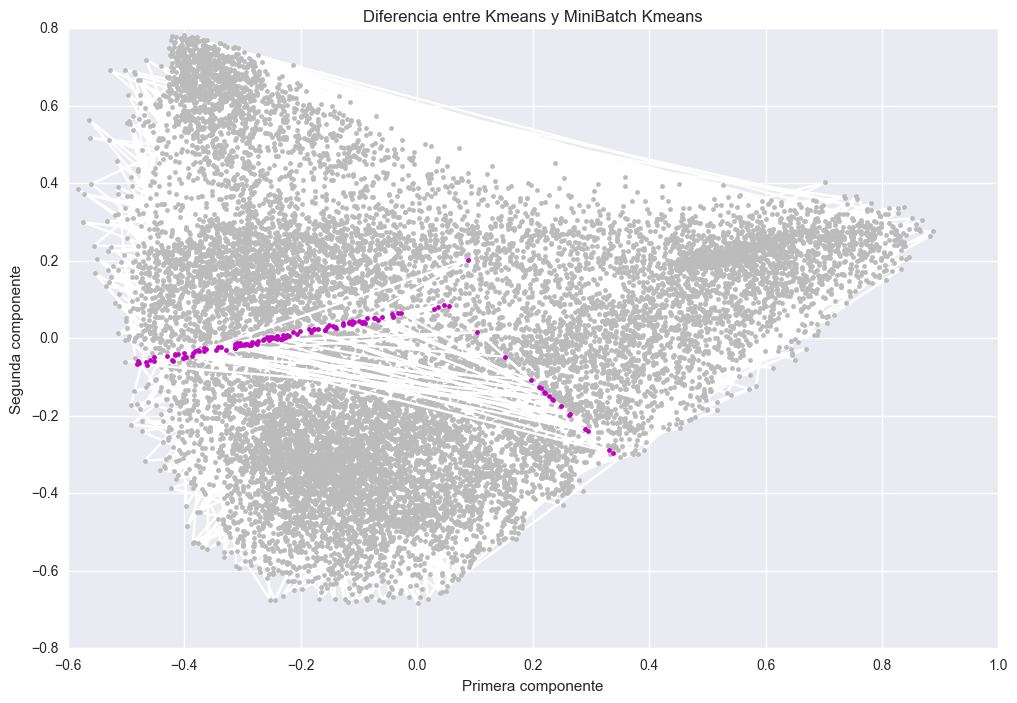

In [45]:
#Código obtenido de http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html

order = pairwise_distances_argmin(kmeans.cluster_centers_,
                                  mbkmeans.cluster_centers_)
# Initialise the different array to all False
different = (mbkmeans.labels_ == 4)

for k in range(3):
    different += ((kmeans.labels_ == k) != (mbkmeans.labels_ == order[k]))

identic = np.logical_not(different)
plt.figure(figsize=(12, 8))
plt.plot(X_red[identic, 0], X_red[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
plt.plot(X_red[different, 0], X_red[different, 1], 'w',
        markerfacecolor='m', marker='.')
plt.title('Diferencia entre Kmeans y MiniBatch Kmeans')
plt.ylabel("Segunda componente")
plt.xlabel("Primera componente")
plt.show()